## Mono/Di-derm phenotype: data analysis, processing, and visualization

#### 1. Read the train and test datasets

In [1]:
import pandas as pd
import numpy as np
import torch
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Add the parent directory to sys.path (to import util function)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.utils import read_diderm_data, pca_run_and_plot, tsne_plot

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_filename_train = "../data_diderm/all_gene_annotations.training.tsv"
data_filename_test = "../data_diderm/all_gene_annotations.testing.tsv"
data_filename_all = "../data_diderm/all_gene_annotations.tsv"
y_filename = "../data_diderm/gold_standard1.tsv"

X_val_all, y_label_all, X_column_names = read_diderm_data(data_filename_all, y_filename, DEVICE) #{'Diderm': 0, 'Monoderm': 1}
X_val_train, y_label_train, X_column_names = read_diderm_data(data_filename_train, y_filename, DEVICE)
X_val_test, y_label_test, X_column_names = read_diderm_data(data_filename_test, y_filename, DEVICE) 
print(f"Train dataset: {len(X_val_train)} samples, {len(X_val_train[0])} features")
print(f"Test dataset: {len(X_val_test)} samples; {len(X_val_test[0])} features")

Train dataset: 741 samples, 2665 features
Test dataset: 187 samples; 2665 features


In [2]:
num_mono_train = float(sum(y_label_train.cpu()))
num_di_train = float(len(y_label_train.cpu()) - num_mono_train)
print(f"Number of Monoderms in train = {num_mono_train}, which is {round(100*num_mono_train/(num_mono_train+num_di_train),2)} %")
print(f"Number of Diderms = {num_di_train}, which is {round(100*num_di_train/(num_mono_train+num_di_train),2)} %\n")

num_mono_test = float(sum(y_label_test.cpu()))
num_di_test = float(len(y_label_test.cpu()) - num_mono_test)
print(f"Number of Monoderms in train = {num_mono_test}, which is {round(100*num_mono_test/(num_mono_test+num_di_test),2)} %")
print(f"Number of Diderms = {num_di_test}, which is {round(100*num_di_test/(num_mono_test+num_di_test),2)} %")

Number of Monoderms in train = 255.0, which is 34.41 %
Number of Diderms = 486.0, which is 65.59 %

Number of Monoderms in train = 61.0, which is 32.62 %
Number of Diderms = 126.0, which is 67.38 %


#### 2. PCA and tSNE projections

Data after PCA reduction: (928, 20)
Explained variance ratio: [0.08478027 0.05232734 0.04322221 0.03318241 0.02698622 0.02266151
 0.01850149 0.01513025 0.01182622 0.01095009 0.00999261 0.0091507
 0.00846712 0.0076498  0.00704701 0.00685952 0.00647719 0.00621019
 0.00575026 0.00559007]
Total explained variance: 0.3927624751914906
Shape of the projected data = (928, 2)


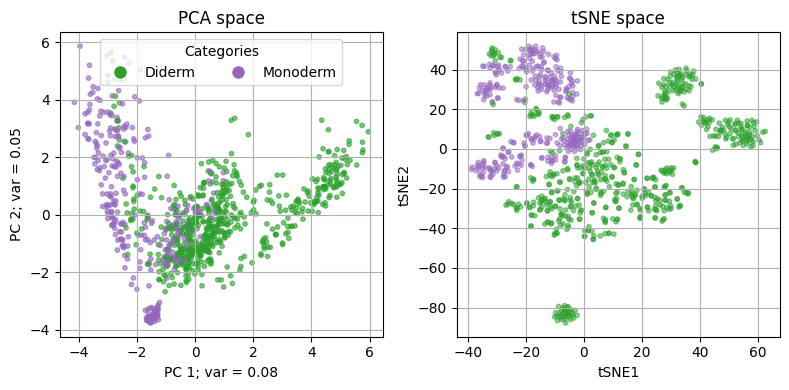

In [11]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = ["Diderm" if yi == 0 else "Monoderm" for yi in y_label_all]
pca_run_and_plot(X_val_all.cpu(), n_compon, y_label_all.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val_all.cpu(), 30, 100, y_label_all.cpu(), colors);

# Display the plots
plt.tight_layout()  
plt.show()

#### 3. XGBoost training and feature selection

First, find baseline (for all GOGs) test and cross-validation accuracy measures.

In [23]:
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features

cv_accuracy_scores, test_accuracy_scores = xgboost_train_accur(X_val_train, y_label_train, X_val_test, y_label_test, DEVICE)
print(f"XGBoost baseline test accuracy (all features) = {test_accuracy_scores}")
print(f"XGBoost cv_accuracy (all features) = {test_accuracy_scores}")

XGBoost baseline test accuracy (all features) = {'accuracy': 0.9946524064171123, 'precision': 0.9838709677419355, 'recall': 1.0, 'f1': 0.991869918699187, 'roc_auc': 0.9979182930002601}
XGBoost cv_accuracy (all features) = {'accuracy': 0.9946524064171123, 'precision': 0.9838709677419355, 'recall': 1.0, 'f1': 0.991869918699187, 'roc_auc': 0.9979182930002601}


In [5]:
# Presence only signal
X_train_numpy_pres_only = torch.tensor((X_val_train.cpu().numpy() > 0).astype(int))
X_test_numpy_pres_only = torch.tensor((X_val_test.cpu().numpy() > 0).astype(int))

cv_accuracy_scores, test_accuracy_scores = xgboost_train_accur(X_train_numpy_pres_only, y_label_train, X_test_numpy_pres_only, y_label_test, DEVICE)
print(f"XGBoost baseline test accuracy (all features) = {test_accuracy_scores}")
print(f"XGBoost cv_accuracy (all features) =  {test_accuracy_scores}")

XGBoost baseline test accuracy (all features) = {'accuracy': 0.9946524064171123, 'precision': 0.9838709677419355, 'recall': 1.0, 'f1': 0.991869918699187, 'roc_auc': 0.9973978662503253}
XGBoost cv_accuracy (all features) =  {'accuracy': 0.9946524064171123, 'precision': 0.9838709677419355, 'recall': 1.0, 'f1': 0.991869918699187, 'roc_auc': 0.9973978662503253}


In [7]:
X_train_np = np.array(X_val_train.cpu())
X_train_transposed = X_train_np.T

#### 3.1 Feature selection with Mutual Information

In [24]:
from feature_selection.feature_selection_utils import mutual_info_features

sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names)

In [25]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(f"Top {N} COGs:", top_N_names_by_mi)

Top 10 COGs: ['COG0795', 'COG0763', 'COG1127', 'COG0767', 'COG1519', 'COG1212', 'COG1663', 'COG0854', 'COG0774', 'COG1995']


Data after PCA reduction: (741, 5)
Explained variance ratio: [0.6174751  0.10979748 0.08409677 0.05290091 0.04448937]
Total explained variance: 0.9087596237659454
Shape of the projected data = (741, 2)


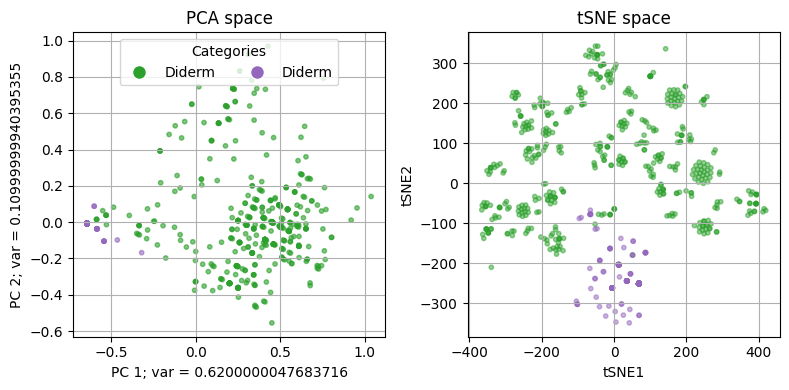

In [ ]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()


In [12]:
from sklearn.preprocessing import MaxAbsScaler

X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

In [13]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

c:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [88]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

0.9514511155450753
0.9090909090909091


In [18]:
def plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat):
    plt.axhline(y=test_accuracy_scores[metric], color='darkred', linestyle='--', linewidth=1.5, label='baseline test')
    plt.axhline(y=cv_accuracy_scores[metric], color='darkblue', linestyle='--', linewidth=1.5, label='baseline CV')

    plt.plot(num_feat, [scores[metric] for scores in test_accur_arr], c = "tab:red", label = "test | add")
    plt.plot(num_feat, [scores[metric] for scores in cv_accur_arr], c = "tab:blue", label = "cv | add")

    plt.plot(num_feat,  [scores[metric] for scores in test_accur_arr_rem], c = "tab:red", label = "test | remove", alpha = 0.5)
    plt.plot(num_feat, [scores[metric] for scores in cv_accur_arr_rem], c = "tab:blue", label = "cv | remove", alpha = 0.5)

    plt.xlabel("number of features added/removed")
    plt.ylabel(metric)

Text(0.5, 0.98, 'Mono/di-derm: XGBoost accuracy metrics for the selected features (MI)')

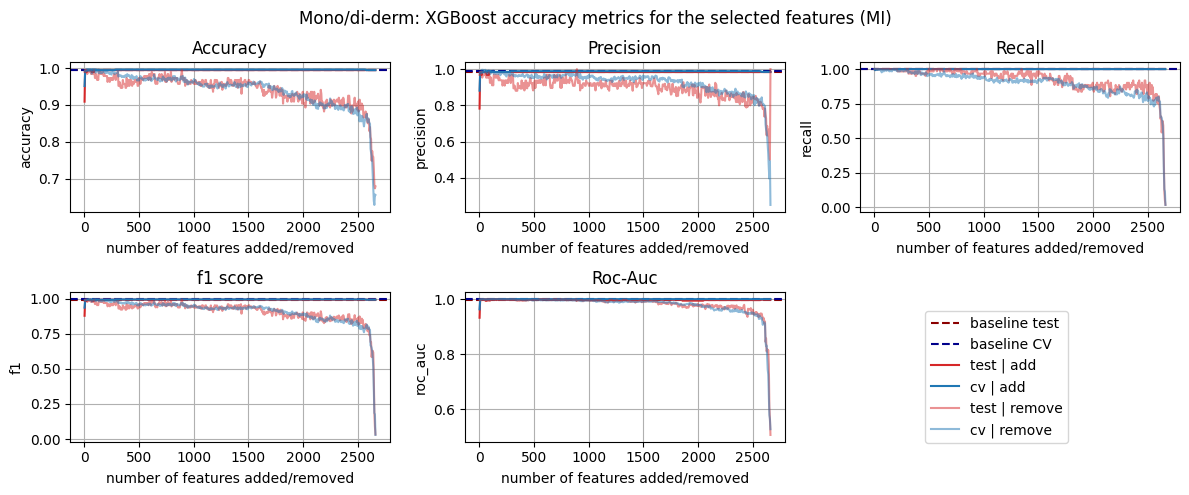

In [ ]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Mono/di-derm: XGBoost accuracy metrics for the selected features (Mutual Information)")

#### 3.2 Feature selection with Random Forest

In [ ]:
from feature_selection.feature_selection_utils import random_forest_features
sorted_cog_idx_by_rand_forest, sorted_importances, sorted_names = random_forest_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names)

Original feature count: 2665, Selected feature count: 313


In [ ]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_rand_forest[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_rand_forest = sorted_names[:N]
top_feat_rand_forest_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]]
print(f"Top {N} COGs:", top_N_names_by_rand_forest)

Top 10 COGs: ['COG1127', 'COG0767', 'COG0763', 'COG1519', 'COG0795', 'COG4783', 'COG1663', 'COG1461', 'COG1212', 'COG1995']


In [ ]:
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]])

Data after PCA reduction: (741, 5)
Explained variance ratio: [0.5873019  0.11553724 0.09244855 0.05412376 0.04828222]
Total explained variance: 0.897693682461977
Shape of the projected data = (741, 2)


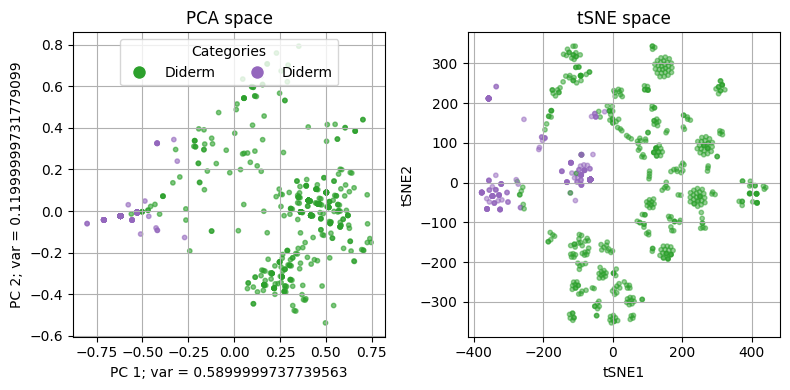

In [ ]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()

In [37]:
from sklearn.preprocessing import MaxAbsScaler

X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

KeyboardInterrupt: 

In [ ]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

0.9257028840921459
0.893048128342246


In [ ]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

Text(0.5, 0.98, 'Mono/di-derm: XGBoost accuracy metrics for the selected features (Random Forest)')

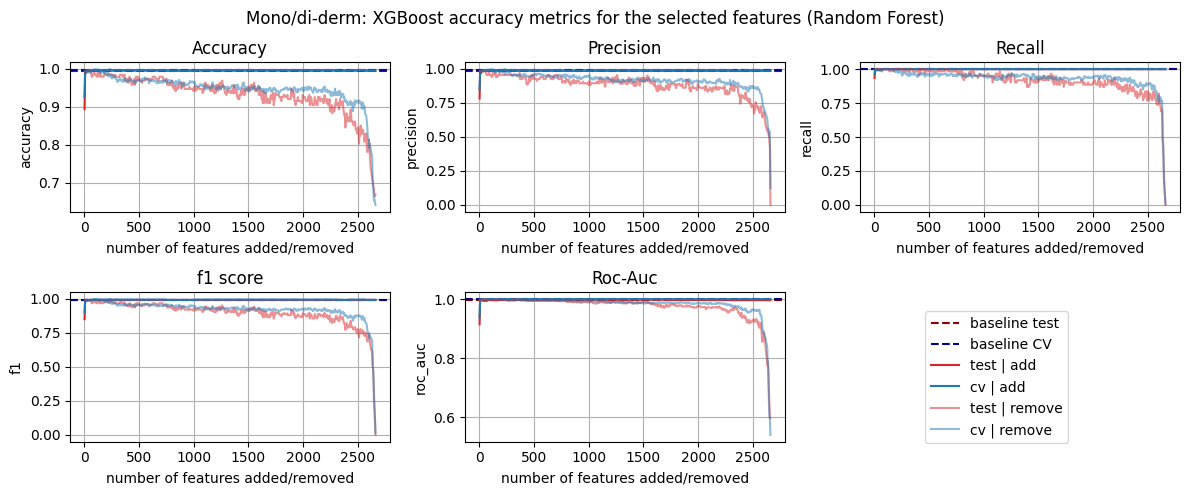

In [ ]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Mono/di-derm: XGBoost accuracy metrics for the selected features (Random Forest)")

#### 3.3 SHAP values

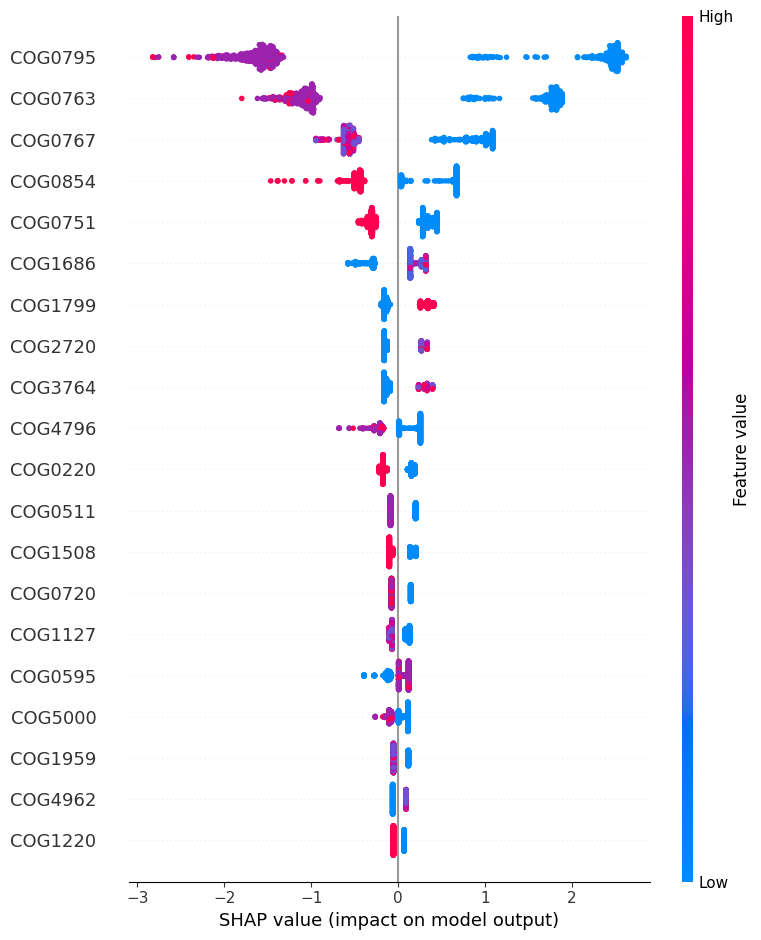

In [ ]:
from feature_selection.feature_selection_utils import shap_features

device = 'cpu'
sorted_cog_idx_by_shap, sorted_shap, sorted_names = shap_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, device) 

In [ ]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_shap[:N]
top_N_mi = sorted_shap[:N]
top_N_names_by_shap = sorted_names[:N]
top_feat_shap_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]]

print(f"Top {N} COGs:", top_N_names_by_shap)

Top 10 COGs: ['COG0795', 'COG0763', 'COG0767', 'COG0854', 'COG0751', 'COG1686', 'COG1799', 'COG2720', 'COG3764', 'COG4796']


Data after PCA reduction: (741, 5)
Explained variance ratio: [0.47940412 0.14420804 0.09698032 0.06955721 0.05495125]
Total explained variance: 0.8451009467244148
Shape of the projected data = (741, 2)


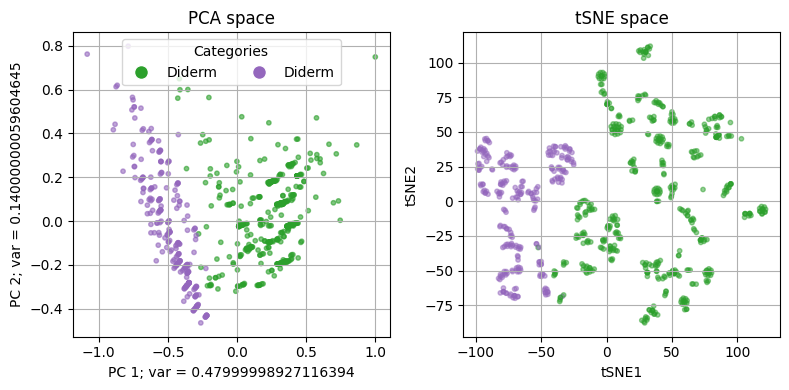

In [ ]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

In [ ]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

Text(0.5, 0.98, 'Mono/di-derm: XGBoost accuracy metrics for the selected features (SHAP values)')

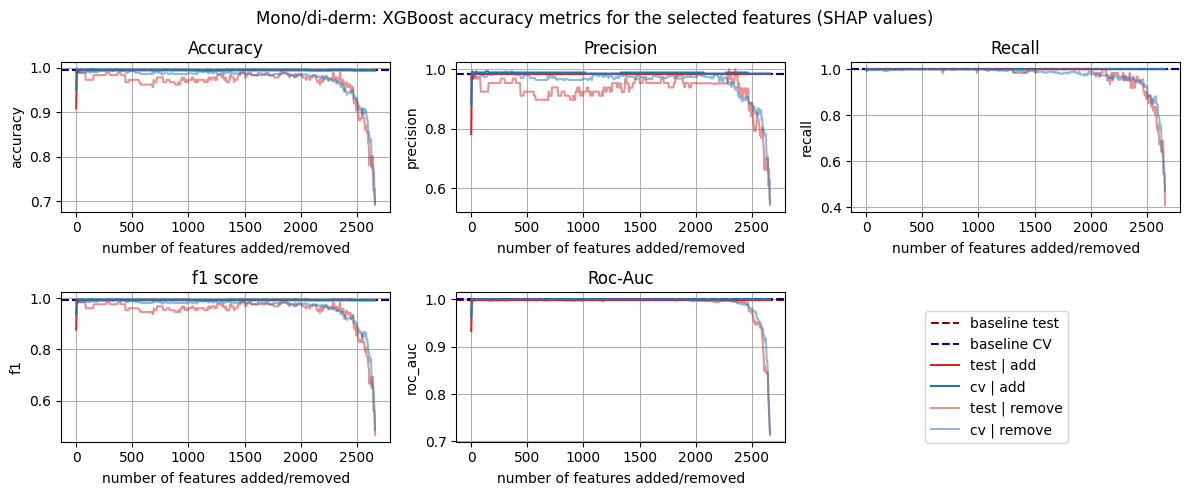

In [ ]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Mono/di-derm: XGBoost accuracy metrics for the selected features (SHAP values)")

In [ ]:
import pandas as pd

# Define the data for the columns
data = {
    'MI': top_N_names_by_mi,
    'RandomForest': top_N_names_by_rand_forest,
    'SHAP': top_N_names_by_shap
}

# Create DataFrame with specified column names
df = pd.DataFrame(data)

# Print the DataFrame
display(df)

,MI,RandomForest,SHAP
0,COG0795,COG1127,COG0795
1,COG0763,COG0767,COG0763
2,COG1127,COG0763,COG0767
3,COG0767,COG1519,COG0854
4,COG1519,COG0795,COG0751
5,COG1212,COG4783,COG1686
6,COG1663,COG1663,COG1799
7,COG0854,COG1461,COG2720
8,COG0774,COG1212,COG3764
9,COG1995,COG1995,COG4796


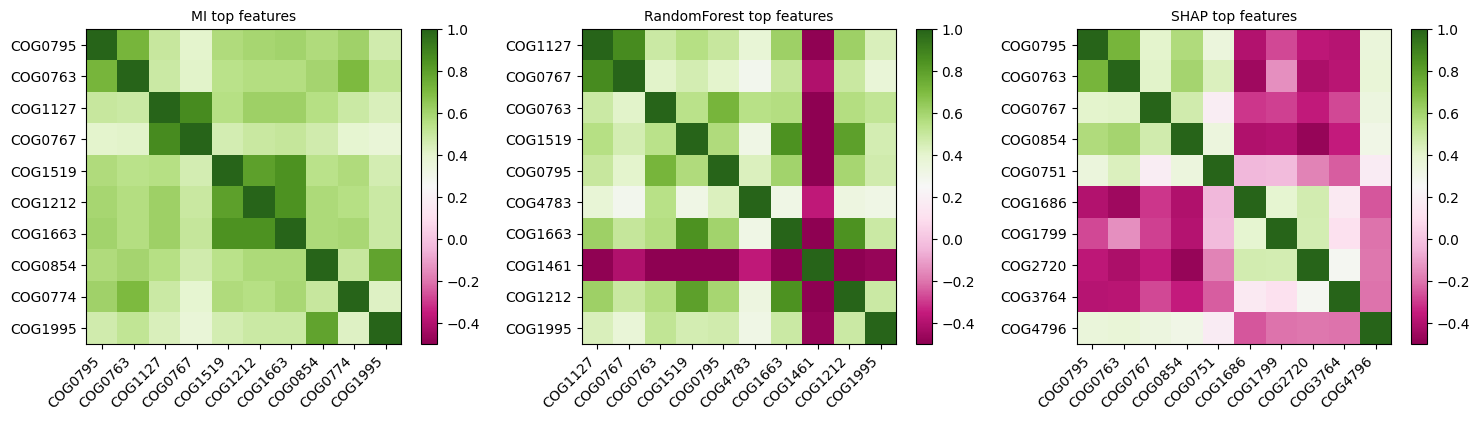

In [ ]:
plt.figure(figsize=(15, 4))

vmin, vmax = -0.5, 1 #-0.6

# Correlation matrix for MI top features
plt.subplot(1, 3, 1) 
correlation_matrix = np.corrcoef(top_feat_mi_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("MI top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi)
plt.colorbar()

# Correlation matrix for RandomForest top features
plt.subplot(1, 3, 2) 
correlation_matrix = np.corrcoef(top_feat_rand_forest_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("RandomForest top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest)
plt.colorbar()

# Correlation matrix for SHAP top features
plt.subplot(1, 3, 3) 
correlation_matrix = np.corrcoef(top_feat_shap_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("SHAP top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap)
plt.colorbar()

# Display the plots
plt.tight_layout()  
plt.show()
